In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CS 663 Project


Mounted at /content/drive
/content/drive/MyDrive/CS 663 Project


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image

import torch
import torch.nn as nn
from torchvision import models, transforms


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])


Using device: cpu


In [11]:
def build_model(weights_path="weights/efficientnet_b0.pth"):
    """
    Rebuild EfficientNet-B0 binary classifier and load trained weights.
    """
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier[1].in_features, 1)
    )

    model = model.to(device)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

model = build_model("detection/weights/raw_best_pneumonia_model.pth")


In [12]:
class GradCAM:

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor):

        self.model.zero_grad()

        logits = self.model(input_tensor)        # shape: (1, 1)
        logit = logits[0, 0]                     # single logit for "pneumonia"
        prob = torch.sigmoid(logit).item()

        logit.backward(retain_graph=True)

        activations = self.activations           # (1, C, Hc, Wc)
        gradients = self.gradients               # (1, C, Hc, Wc)

        weights = gradients.mean(dim=(2, 3), keepdim=True)   # (1, C, 1, 1)

        cam = (weights * activations).sum(dim=1, keepdim=True)  # (1, 1, Hc, Wc)

        cam = torch.relu(cam)

        cam = cam.squeeze(0).squeeze(0)  # (Hc, Wc)
        cam_min, cam_max = cam.min(), cam.max()
        if (cam_max - cam_min) > 1e-8:
            cam = (cam - cam_min) / (cam_max - cam_min)
        else:
            cam = torch.zeros_like(cam)

        return cam.detach().cpu().numpy(), prob


In [13]:
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

In [5]:
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = test_transforms(img).unsqueeze(0).to(device)
    return img, input_tensor


In [6]:
def overlay_cam_on_image(pil_img, cam, alpha=0.4):

    img_rgb = np.array(pil_img)  # (H, W, 3) in RGB

    H, W = img_rgb.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # convert to RGB

    if img_rgb.ndim == 2:
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)

    overlay = (alpha * heatmap + (1 - alpha) * img_rgb).astype(np.uint8)
    return overlay


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


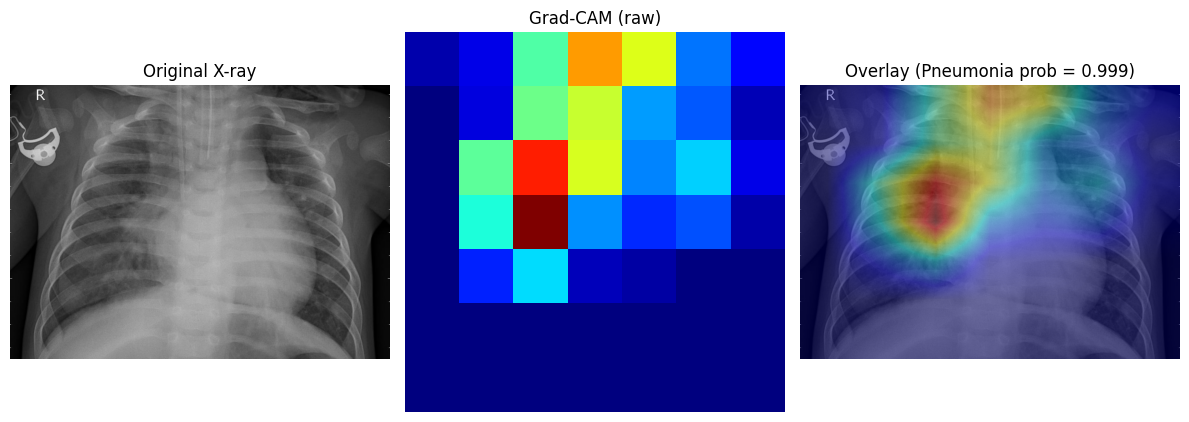

In [14]:
example_path = "data_binary_classification/test/PNEUMONIA/person80_bacteria_391.jpeg"  # <-- change this

pil_img, input_tensor = load_image(example_path)
cam, prob = gradcam.generate_cam(input_tensor)
overlay = overlay_cam_on_image(pil_img, cam, alpha=0.4)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(pil_img, cmap='gray')
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM (raw)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay (Pneumonia prob = {prob:.3f})")
plt.axis("off")

plt.tight_layout()
plt.show()
